# Demostrate to build a Statistical and Semantic features driven classifier on Crisis Data.

This notebook is meant to walk through step by step process of developing machine learning classifiers to distinguish between crisis related and not related data. Methods involving Statistical features and Semantic features are explained, including the ways to collect the semantics.

In [1]:
# Confirm the enviroment - You should have a Python 3 instance running
import sys

print(sys.executable)
print (sys.version)
print(sys.version_info)

/Applications/anaconda/envs/py36_env/bin/python
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


In [2]:
# coding: utf8

# load required libraries
import spacy
import csv
import re
import pandas as pd
import numpy as np
import scipy as sp
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
from nltk.tokenize import regexp_tokenize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as prfs_score
from sklearn import cross_validation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.externals import joblib
import pickle
import json

import codecs
import csv

/Applications/anaconda/envs/py36_env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Upload Training and Test Data (if using a test file)

For this tutorial we use the CrisisLexT26 corpus containing Tweets from 26 crises, labeled by informativeness, information type and source. The collection includes tweets collected during 26 large crisis events in 2012 and 2013, with about 1,000 tweets labeled per crisis for relatedness and informativeness (i.e. “Related & informative," or "Related & not informative","Not Related", and "Not Applicable), information type, and source. As shown [1] and [2], we merge labels to narrow down the labels to 2 labels : "Related" and "Not Related".

Here we use Queensland Flood and Guatemala Earthquake events for analysis.

In [3]:
train_file = '../data/QFL.csv'
#test_file = '../data/CFL.csv'

In [4]:
# Upload a customised multi-lingual stopword dictionary

data_json = json.load(codecs.open(
    '../data/selected_lang_stopwords.json', 'r', 'utf-8'))

s = set(data_json['en'])
fs = frozenset(s)

Upload language model in spaCy- the natural language processing library

In [5]:
nlp_en = spacy.load('en')

nlp = nlp_en

# Define Statistical Feature extraction method

Statistical Features have been defined in [1] and [2], for each tweet as:
    
– Number of nouns: nouns generally refer to different entities involved in the crisis event such as locations, actors, or resources involved in the crisis event.

– Number of verbs: verbs indicate actions that occur in a crisis event.

– Number of pronouns: as with nouns, pronouns may indicate involvement of
the actors, locations, or resources.

– Tweet Length: number of characters in a post. The length of a post may
determine the amount of information contained.

– Number of words: number of words may be another indicator of the amount
of information contained within a post.

– Number of Hashtags: hashtags reflect the themes of the post and are manually
generated by the posts’ authors.

– Unigrams: The entire data (text of each post) is tokenised and represented
as unigrams.

In [6]:
def extract_statfeatures(tweet):
    string = tweet
    
    dict_pos = dict()

    #doc = nlp(string.decode('utf-8')) # python 2 requirement
    
    doc = nlp(string)

    for token in doc:

        #if dict_pos.has_key(token.pos_):
        if token.pos_ in dict_pos:

            dict_pos[token.pos_] = dict_pos[token.pos_] + 1

        else:

            dict_pos[token.pos_] = 1

    pronouns = 0
    nouns = 0
    verbs = 0

    if 'PRON' in dict_pos:
        pronouns = dict_pos['PRON']

    if 'NOUN' in dict_pos:
        nouns = dict_pos['NOUN']

    if 'PROPN' in dict_pos:
        nouns = dict_pos['PROPN'] + nouns

    if 'VERB' in dict_pos:
        verbs = dict_pos['VERB']

    tweet_length = len(string)
    token_count = len(re.findall(r'\w+', string))
    numHashTag = len([i for i in string.split() if i.startswith("#")])
 
    return pronouns, nouns, verbs, tweet_length, token_count, numHashTag


In [7]:
t = ['Document', 'NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns',
         'TweetLength', 'NumberOfWords', 'NumberOfHashTag']

In [8]:
# first pass loading the training data

with open(train_file,'r') as fline:
    
    data_csv = list(csv.reader(fline, delimiter="\t", quoting=csv.QUOTE_NONE))

    data = np.array(data_csv[0:])
    
    data_train = np.empty(shape=(len(data_csv),7),dtype='|S300')
    
    # the labels/class for each document
    #label_train = data[:, 4].astype(np.float32)
    label_train = data[:, 2].astype(np.float32)


In [9]:
# sneak preview of the data

pd.DataFrame(data, columns=['tweetID','tweet','class']).head()

,tweetID,tweet,class
0,295416901943828481,RT if you are older than 9 #bigwet #getinvolved,0
1,295457192436441088,#qldfloods lmao. Whoever put those things were...,0
2,293925403238748161,#QLD Police: #bigwet Bruce H'Way near Mobil S...,1
3,297106476630155264,RT @ACPMH: Check out @beyondblue looking after...,1
4,295737736831324161,HANDY list of contacts and numbers. Have a loo...,1


In [10]:
# creating the statistical features of the training data
for i in range(0,data.shape[0]):
    
    pronouns, nouns, verbs, tweet_length, token_count, numHashTag = extract_statfeatures(str(data[i][1]))
    
    data_train[i][0] = data[i][1].encode('utf8')
    
    data_train[i][1] = int(nouns)
    data_train[i][2] = int(verbs)
    data_train[i][3] = int(pronouns)
    data_train[i][4] = int(tweet_length)
    data_train[i][5] = int(token_count)
    data_train[i][6] = int(numHashTag)

In [11]:
frame_train = pd.DataFrame(data_train, columns=t)

In [12]:
# Just check how the data frame looks like

frame_train.head()

,Document,NumberOfNouns,NumberOfVerbs,NumberOfPronouns,TweetLength,NumberOfWords,NumberOfHashTag
0,b'RT if you are older than 9 #bigwet #getinvol...,b'4',b'2',b'1',b'47',b'9',b'2'
1,b'#qldfloods lmao. Whoever put those things we...,b'5',b'3',b'1',b'122',b'22',b'1'
2,"b""#QLD Police: #bigwet Bruce H'Way near Mobil...",b'12',b'1',b'0',b'107',b'18',b'2'
3,b'RT @ACPMH: Check out @beyondblue looking aft...,b'10',b'2',b'1',b'140',b'21',b'2'
4,b'HANDY list of contacts and numbers. Have a l...,b'7',b'6',b'1',b'125',b'23',b'2'


# Transform the data to vectors

In [13]:
vectorizer = CountVectorizer(analyzer='word',
                                 stop_words=fs, lowercase=True, ngram_range=(1, 1), max_features=40000)

doc_vectorize = vectorizer.fit_transform(frame_train.Document)
tf_transform = TfidfTransformer()
tf_vectorize = tf_transform.fit_transform(doc_vectorize)

In [14]:
data_train_stack = sp.sparse.hstack((tf_vectorize, frame_train[['NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns', 'TweetLength',
                                                  'NumberOfWords', 'NumberOfHashTag']].values.astype(np.float32)), format='csr')


In [15]:
# confirm the stack shape
print ('tf-vectorizer shape: ',tf_vectorize.shape)
print ('overall feature stack shape: ',data_train_stack.shape)

tf-vectorizer shape:  (556, 2329)
overall feature stack shape:  (556, 2335)


In [16]:
# check the data distribution class vice
unique, counts = np.unique(label_train, return_counts=True)
print (dict(zip(unique, counts)))

{0.0: 278, 1.0: 278}


# Declare the classifier and fit on the training data

In [17]:
# Define SVC kernel and fit

svc = SVC(kernel='linear', degree=3, gamma='auto', tol=0.001)

svc.fit(data_train_stack, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Declare calling methods for the test data.

We create the methods to test on a text of test tweet.

In [18]:
def get_test_tweet_features(test_tweet):
    
    pronouns, nouns, verbs, tweet_length, token_count, numHashTag = extract_statfeatures(test_tweet)
    
    data_test = np.array([[test_tweet, nouns, verbs, pronouns,
                               tweet_length, token_count, numHashTag]])
    return data_test

In [19]:
def classify_tweet(test_tweet):

    data_test = get_test_tweet_features(test_tweet)

    frame_test = pd.DataFrame(data_test, columns=t)
    
    test_vectorize = vectorizer.transform(frame_test.Document)
    test_tf_vectorize = tf_transform.transform(test_vectorize)

    data_test_stack = sp.sparse.hstack((test_tf_vectorize, frame_test[['NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns',
                                                                 'TweetLength', 'NumberOfWords', 'NumberOfHashTag']].values.astype(np.float32)), format='csr')
    
    label_test_predict = svc.predict(data_test_stack)
    
    return json.dumps({'class': str(label_test_predict[0])})

# End API call 

Results a json response of 'class' indicating 1.0 (crisis related) or 0.0 (not related)

In [20]:
print (classify_tweet('The car got drowned in the heavy flood.'))
print (classify_tweet('The building collapsed in the heavy rainfall.'))

{"class": "1.0"}
{"class": "0.0"}


# Semantic Transformation of the Data

Semantic features are designed to generalise information representation across crises. They are designed to be less crisis specific compared to statistical features [1] & [2]. We use the Name Entity Recogniser (NER) service Babelfy to collect the following:

– Babelfy Entities: the entities extracted by the BabelNet NER tool (e.g., news, sadness, terremoto). Babelfy extracts and disambiguates entities linked to the BabelNet knowledge base.

– BabelNet Senses (English): the English labels associated with the entities re- turned by Babelfy (e.g., news news, sadness sadness, terremoto earthquake).

– BabelNet Hypernyms (English): the direct English hypernyms (at distance- 1) of each entities extracted from BableNet. Hypernyms can broaden the context of an entity, and can enhance the semantics of a document (e.g., broadcasting, communiucation, emotion).

Create a BabelNet Key

In [21]:
#import urllib2
import urllib.request #for urllib2
import urllib.error #for urllib2
from urllib.request import urlopen

import urllib
import json
import gzip

from io import StringIO
from io import BytesIO

#from StringIO import StringIO #python2 version


# BabelNet Key : http://babelnet.org/ or Babelfy Key : http://babelfy.org/
key  = ''

# Define methods for calling annotation/disambiguation API, sense gathering, and semantic neighbours (hypernyms) 

In [22]:
# text annotation, returns a list of annotated SynsetIDs
def get_synsetID_text(text):
    
    service_url = 'https://babelfy.io/v1/disambiguate'

    lang = 'EN'
    
    synset_list = []
    
    params = {
        'text' : text,
        'lang' : lang,
        'key'  : key
    }

    #url = service_url + '?' + urllib.urlencode(params) #Python 2
    url = service_url + '?' + urllib.parse.urlencode(params)
    
    #request = urllib2.Request(url)
    request = urllib.request.Request(url)
    
    request.add_header('Accept-encoding', 'gzip')
    
    #response = urllib2.urlopen(request)
    response = urllib.request.urlopen(request)

    if response.info().get('Content-Encoding') == 'gzip':
        
        # buf = StringIO( response.read()) # Python2
        buf = BytesIO( response.read())
        f = gzip.GzipFile(fileobj=buf)
        data = json.loads(f.read())

        # retrieving data
        for result in data:
            
            # retrieving char fragment
            charFragment = result.get('charFragment')
            cfStart = charFragment.get('start')
            cfEnd = charFragment.get('end')
            #print str(cfStart) + "\t" + str(cfEnd)


            # retrieving BabelSynset ID
            synsetId = result.get('babelSynsetID')
            synset_list.append([text[cfStart:cfEnd+1],synsetId])
            #print text[cfStart:cfEnd+1],' ',synsetId
            
    return synset_list

In [23]:
# retrieve the sense for each SynsetID, returns a dictionary for associated senses in English for each SynsetID
def get_babel_sense(id):
    
    service_url = 'https://babelnet.io/v5/getSynset'

    lang ='EN'
    sense_dict = dict()
    params = {
        'id' : id,
        'key'  : key,
        'targetLang' : lang
    }

    #url = service_url + '?' + urllib.urlencode(params) #Python 2
    url = service_url + '?' + urllib.parse.urlencode(params)
    
    #request = urllib2.Request(url) #Python 2
    request = urllib.request.Request(url)
    
    request.add_header('Accept-encoding', 'gzip')
    
    #response = urllib2.urlopen(request) # Python 2
    response = urllib.request.urlopen(request)

    if response.info().get('Content-Encoding') == 'gzip':
        #buf = StringIO( response.read()) #Python 2
        buf = BytesIO( response.read())
        f = gzip.GzipFile(fileobj=buf)
        data = json.loads(f.read())
        
        # retrieving BabelSense data
        senses = data['senses']
        for result in senses:
            
            #language = result.get('language')
            #print language.encode('utf-8') + "\t" + str(lemma.encode('utf-8'))
            if result['properties']['fullLemma'].lower() not in sense_dict:
                sense_dict[result['properties']['fullLemma'].lower()] = 1
            #print result['properties']['fullLemma']
            
    return sense_dict

In [24]:
# retrieve the neighbours of each SynsetID, in this case we extract Hypernyms to broaden the context
def get_babel_neighbours(id):
    
    service_url = 'https://babelnet.io/v5/getOutgoingEdges'

    #id = 'bn:00007287n'
    hyper_list = []
    lang = 'EN'
    params = {
        'id' : id,
        'key'  : key
    }

    #url = service_url + '?' + urllib.urlencode(params)  #Python 2
    url = service_url + '?' + urllib.parse.urlencode(params)
    
    #request = urllib2.Request(url) #Python 2
    request = urllib.request.Request(url)
    request.add_header('Accept-encoding', 'gzip')
    
    #response = urllib2.urlopen(request) #Python 2
    response = urllib.request.urlopen(request)

    if response.info().get('Content-Encoding') == 'gzip':
        #buf = StringIO( response.read()) #Python 2
        buf = BytesIO( response.read())
        f = gzip.GzipFile(fileobj=buf)
        data = json.loads(f.read())
        
        # retrieving Edges data
        for result in data:
            
            target = result['target']
            
            language = result['language']

            # retrieving BabelPointer data
            pointer = result['pointer']
            relation = pointer.get('name')
            group = pointer.get('relationGroup')

            # Types of relationGroup: HYPERNYM,  HYPONYM, MERONYM, HOLONYM, OTHER
            #if ('hypernym' in group.lower() or 'hyponym' in group.lower()):

            if ('hypernym' in group.lower()) and str(language)=='EN':
                    #print (str(language) + "\t" + str(target) + "\t" + str(relation) + "\t" + str(group))
                    hyper_list.append([id, str(target), str(relation)])
                    
                    
            #elif ('antonym' in relation.lower()):
             #       print (str(language) + "\t" + str(target) + "\t" + str(relation) + "\t" + str(group))

    return hyper_list

# Semantify a sample tweet

In [25]:
# test the use case

tweet = 'The building collapsed in the heavy rainfall.'
overall_concept = tweet

In [26]:
# Get SynsetIDs in the text
synset_list_return = get_synsetID_text(tweet)

synset_list_return

[['building', 'bn:00084198v'],
 ['collapsed', 'bn:00085281v'],
 ['heavy', 'bn:00104050a'],
 ['rainfall', 'bn:00066032n']]

In [27]:
# Get Sense in English for each Syset ID
for i in range(0, len(synset_list_return)):
    
    sense_dictonary = get_babel_sense(synset_list_return[i][1])
    
    for j in sense_dictonary.keys():
        
        overall_concept = overall_concept.strip() + ' ' + j.strip()

In [28]:
overall_concept

'The building collapsed in the heavy rainfall. construct build make produce collapse heavy rain rainfall rain_water rainwater raining hyetal intensity_frequency_and_duration pissing_it_down pluviophile rain_measurement rain_storm raindrops rained rainfall_intensity rainiest rains rainstorm rainy torrential_rain wettest_places_on_earth wettest_spot_on_earth ⛆ 🌦 🌧 heavy_rain_(meteorology)'

In [29]:
# Get neighbour SynsetIDs (hypernyms) for each SynsetID

for i in range(0, len(synset_list_return)):
    
    neighbour_list = get_babel_neighbours(synset_list_return[i][1])
    
    for j in range(0, len(neighbour_list)):
        
        # Get sense of each neighbouring Synset ID
        
        neighbour_sense_dictonary = get_babel_sense(neighbour_list[j][1])
        
        for k in neighbour_sense_dictonary.keys():
        
            overall_concept = overall_concept.strip() + ' ' + k.strip()

In [30]:
overall_concept

'The building collapsed in the heavy rainfall. construct build make produce collapse heavy rain rainfall rain_water rainwater raining hyetal intensity_frequency_and_duration pissing_it_down pluviophile rain_measurement rain_storm raindrops rained rainfall_intensity rainiest rains rainstorm rainy torrential_rain wettest_places_on_earth wettest_spot_on_earth ⛆ 🌦 🌧 heavy_rain_(meteorology) make create fold fold_up turn_up precipitation downfall atmospheric_precipitation hydrometeor annual_precipitation atmospheric_hydrometeor classification_of_clouds cloud_condensation convectional_precipitation cumulonimbus_praecipitatio hydrometeors praecipitation precipitaion precipitaiton precipitation_measurement precipitation_(meteorology)'

# Semantic Enrichment Based Classification

For the tutorial we pre-trained a semantic model.

In [31]:
# Loading already created model

filename = "../data/SVC_classifier_model_py3.pkl"
loaded_model = pickle.load(open(filename, "rb"))

filename_vectorize = "../data/vectorizer_py3.pkl"
filename_tf_transform = "../data/tf_transform_py3.pkl"

loaded_vectorizer = pickle.load(open(filename_vectorize, "rb"))
loaded_tf_transform = pickle.load(open(filename_tf_transform, "rb"))


/Applications/anaconda/envs/py36_env/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.18.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Applications/anaconda/envs/py36_env/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Applications/anaconda/envs/py36_env/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [32]:
def semantic_enrichment(tweet):
    
    enriched_tweet = tweet
    
    synset_list_return = get_synsetID_text(tweet)
    
    # Get Sense in English for each Syset ID
    for i in range(0, len(synset_list_return)):

        sense_dictonary = get_babel_sense(synset_list_return[i][1])

        for j in sense_dictonary.keys():

            enriched_tweet = enriched_tweet.strip() + ' ' + j.strip()
            
    # Get neighbour SynsetIDs (hypernyms) for each SynsetID

    for i in range(0, len(synset_list_return)):

        neighbour_list = get_babel_neighbours(synset_list_return[i][1])

        for j in range(0, len(neighbour_list)):

            # Get sense of each neighbouring Synset ID

            neighbour_sense_dictonary = get_babel_sense(neighbour_list[j][1])

            for k in neighbour_sense_dictonary.keys():

                enriched_tweet = enriched_tweet.strip() + ' ' + k.strip()
                
    return enriched_tweet

In [33]:
test_sem_tweet = 'The building collapsed in the heavy rainfall.'

In [34]:
enriched_tweet_response = semantic_enrichment(test_sem_tweet)

In [35]:
pronouns, nouns, verbs, tweet_length, token_count, numHashTag = extract_statfeatures(test_sem_tweet)
    
data_sem_test = np.array([[enriched_tweet_response, nouns, verbs, pronouns, tweet_length, token_count, numHashTag]])

In [36]:
data_sem_test

array([['The building collapsed in the heavy rainfall. construct build make produce collapse heavy rain rainfall rain_water rainwater raining hyetal intensity_frequency_and_duration pissing_it_down pluviophile rain_measurement rain_storm raindrops rained rainfall_intensity rainiest rains rainstorm rainy torrential_rain wettest_places_on_earth wettest_spot_on_earth ⛆ 🌦 🌧 heavy_rain_(meteorology) make create fold fold_up turn_up precipitation downfall atmospheric_precipitation hydrometeor annual_precipitation atmospheric_hydrometeor classification_of_clouds cloud_condensation convectional_precipitation cumulonimbus_praecipitatio hydrometeors praecipitation precipitaion precipitaiton precipitation_measurement precipitation_(meteorology)',
        '2', '1', '0', '45', '7', '0']], dtype='<U734')

In [37]:
frame_sem_test = pd.DataFrame(data_sem_test, columns=t)

test_sem_vectorize = loaded_vectorizer.transform(frame_sem_test.Document)
test_sem_tf_vectorize = loaded_tf_transform.transform(test_sem_vectorize)

data_sem_test_stack = sp.sparse.hstack((test_sem_tf_vectorize, frame_sem_test[['NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns',
                                                             'TweetLength', 'NumberOfWords', 'NumberOfHashTag']].values.astype(np.float32)), format='csr')

label_sem_test_predict = loaded_model.predict(data_sem_test_stack)

json.dumps({'class': str(label_sem_test_predict[0])})

'{"class": "1.0"}'

# A Performance Evaluation Between Statistical And Semantic Models

We statistical and semantic models on the balanced dataset from Queensland Flood. The balanced dataset contains same number of tweets for both Related and Not Related classes. The tweets were randomly selected from the orginal dataset.

We test the models on Guatemala Earthquake event.

# A. Analyse Statistical Model

In [38]:
train_file_A = '../data/QFL_balanced_stat_random.csv'
test_file_B = '../data/GAU_balanced_stat_random.csv'

In [39]:
with open(train_file_A) as train_fileA:
    
    data_A_csv = list(csv.reader(train_fileA, delimiter="\t", quoting=csv.QUOTE_NONE))
    
    data_A = np.array(data_A_csv[0:])
    
    data_A_features = data_A[:, [1, 7, 8, 9, 10, 11, 12]]
    
    label_A = data_A[:, 4].astype(np.float32)
    
    frame_A = pd.DataFrame(data_A_features, columns=t)
    
    vectorizer_A = CountVectorizer(analyzer='word',
                                 stop_words=fs, lowercase=True, ngram_range=(1, 1), max_features=40000)
    
    doc_vectorize_A = vectorizer_A.fit_transform(frame_A.Document)
    
    tf_transform_A = TfidfTransformer()
    
    tf_vectorize_A = tf_transform_A.fit_transform(doc_vectorize_A)
    
    data_A_stack = sp.sparse.hstack((tf_vectorize_A, frame_A[['NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns', 'TweetLength',
                                                  'NumberOfWords', 'NumberOfHashTag']].values.astype(np.float32)), format='csr')

In [40]:
# sneak preview of data

pd.DataFrame(data_A_features,columns=t).head()

,Document,NumberOfNouns,NumberOfVerbs,NumberOfPronouns,TweetLength,NumberOfWords,NumberOfHashTag
0,RT if you are older than 9 #bigwet #getinvolved,4,2,1,47,9,2
1,#qldfloods lmao. Whoever put those things were...,5,3,1,122,22,1
2,#QLD Police: #bigwet Bruce H'Way near Mobil S...,12,1,0,107,18,2
3,RT @ACPMH: Check out @beyondblue looking after...,10,2,1,140,21,2
4,HANDY list of contacts and numbers. Have a loo...,7,6,1,125,23,2


In [41]:
#Verify the shapes
print (data_A_features.shape)
print (tf_vectorize_A.shape)
print (data_A_stack.shape)

(556, 7)
(556, 2329)
(556, 2335)


In [42]:
unique, counts = np.unique(label_A, return_counts=True)
print (dict(zip(unique, counts)))

{0.0: 278, 1.0: 278}


In [43]:
svc = SVC(kernel='linear', degree=3, gamma='auto', tol=0.001)
svc.fit(data_A_stack, label_A)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
with open(test_file_B) as test_fileB:
    
    data_B_csv = list(csv.reader(test_fileB, delimiter="\t", quoting=csv.QUOTE_NONE))
    
    data_B = np.array(data_B_csv[0:])
    
    data_B_features = data_B[:, [1, 7, 8, 9, 10, 11, 12]]
    
    label_B = data_B[:, 4].astype(np.float32)
    
    frame_B = pd.DataFrame(data_B_features, columns=t)
    
    doc_vectorize_B = vectorizer_A.transform(frame_B.Document)

    tf_vectorize_B = tf_transform_A.transform(doc_vectorize_B)

    data_B_stack = sp.sparse.hstack((tf_vectorize_B, frame_B[['NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns',
                                                                     'TweetLength', 'NumberOfWords', 'NumberOfHashTag']].values.astype(np.float32)), format='csr')


In [45]:
#Verify the shapes
print (data_B_features.shape)
print (tf_vectorize_B.shape)
print (data_B_stack.shape)

(206, 7)
(206, 2329)
(206, 2335)


In [46]:
unique_B, counts_B = np.unique(label_B, return_counts=True)
print (dict(zip(unique_B, counts_B)))

{0.0: 103, 1.0: 103}


In [47]:
label_B_predict = svc.predict(data_B_stack)

In [48]:
print (label_B_predict.shape)

(206,)


In [49]:
print('overall precision score: {}'.format(
            precision_score(label_B, label_B_predict.astype(np.float32), average='macro')))
print('overall recall score: {}'.format(
    recall_score(label_B, label_B_predict.astype(np.float32), average='macro')))
print('overall f-1 score: {}'.format(f1_score(label_B,
                                              label_B_predict.astype(np.float32), average='macro')))
print('confusion matrix: {}'.format(confusion_matrix(label_B, label_B_predict.astype(np.float32))))
print ('************ Classification Report ************')
print (classification_report(label_B, label_B_predict.astype(np.float32)))

overall precision score: 0.6251823043266893
overall recall score: 0.6213592233009708
overall f-1 score: 0.6184460486322187
confusion matrix: [[55 48]
 [30 73]]
************ Classification Report ************
             precision    recall  f1-score   support

        0.0       0.65      0.53      0.59       103
        1.0       0.60      0.71      0.65       103

avg / total       0.63      0.62      0.62       206



# B. Analyse Semantic Model

For the tutorial we pre-curated the semantic features and statistical features for both train and test datasets, i.e. Queensland Flood and Guatemala Earthquake. We created the features through the exact same process as described in the sections above. Here, we train the semantic model on Queensland Floods data and test on Guatemala Earthquake.

In [50]:
train_sem_file_A = '../data/QFL_balanced_random_stat_babel_semantics.csv'
test_sem_file_B = '../data/GAU_balanced_random_stat_babel_semantics.csv'

In [51]:
with open(train_sem_file_A) as train_sem_fileA:
    
    data_sem_A_csv = list(csv.reader(train_sem_fileA, delimiter="\t", quoting=csv.QUOTE_NONE))
    
    data_sem_A = np.array(data_sem_A_csv[0:])
    
    data_sem_A_features = data_sem_A[:, 1:8]
    
    label_sem_A = data_sem_A[:, 8].astype(np.float32)
    
    frame_sem_A = pd.DataFrame(data_sem_A_features, columns=t)
    
    vectorizer_sem_A = CountVectorizer(analyzer='word',
                                 stop_words=fs, lowercase=True, ngram_range=(1, 1), max_features=40000)
    
    doc_vectorize_sem_A = vectorizer_sem_A.fit_transform(frame_sem_A.Document)
    
    tf_transform_sem_A = TfidfTransformer()
    
    tf_vectorize_sem_A = tf_transform_sem_A.fit_transform(doc_vectorize_sem_A)
    
    data_sem_A_stack = sp.sparse.hstack((tf_vectorize_sem_A, frame_sem_A[['NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns', 'TweetLength',
                                                  'NumberOfWords', 'NumberOfHashTag']].values.astype(np.float32)), format='csr')

In [52]:
print (data_sem_A_features.shape)
print (tf_vectorize_sem_A.shape)
print (data_sem_A_stack.shape)

(556, 7)
(556, 4578)
(556, 4584)


In [53]:
unique_semA, counts_semA = np.unique(label_sem_A, return_counts=True)
print (dict(zip(unique_semA, counts_semA)))

{0.0: 278, 1.0: 278}


In [54]:
svc_sem = SVC(kernel='linear', degree=3, gamma='auto', tol=0.001)
svc_sem.fit(data_sem_A_stack, label_sem_A)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
with open(test_sem_file_B) as test_sem_fileB:
    
    data_sem_B_csv = list(csv.reader(test_sem_fileB, delimiter="\t", quoting=csv.QUOTE_NONE))
    
    data_sem_B = np.array(data_sem_B_csv[0:])
    
    data_sem_B_features = data_sem_B[:, 1:8]
    
    label_sem_B = data_sem_B[:, 8].astype(np.float32)
    
    frame_sem_B = pd.DataFrame(data_sem_B_features, columns=t)
    
    doc_vectorize_sem_B = vectorizer_sem_A.transform(frame_sem_B.Document)

    tf_vectorize_sem_B = tf_transform_sem_A.transform(doc_vectorize_sem_B)

    data_sem_B_stack = sp.sparse.hstack((tf_vectorize_sem_B, frame_sem_B[['NumberOfNouns', 'NumberOfVerbs', 'NumberOfPronouns',
                                                                     'TweetLength', 'NumberOfWords', 'NumberOfHashTag']].values.astype(np.float32)), format='csr')


In [56]:
print (data_sem_B_features.shape)
print (tf_vectorize_sem_B.shape)
print (data_sem_B_stack.shape)

(206, 7)
(206, 4578)
(206, 4584)


In [57]:
unique_semB, counts_semB = np.unique(label_sem_B, return_counts=True)
print (dict(zip(unique_semB, counts_semB)))

{0.0: 103, 1.0: 103}


In [58]:
label_sem_B_predict = svc_sem.predict(data_sem_B_stack)

In [59]:
print (label_sem_B_predict.shape)

(206,)


In [60]:
print('overall precision score: {}'.format(
            precision_score(label_sem_B, label_sem_B_predict.astype(np.float32), average='macro')))
print('overall recall score: {}'.format(
    recall_score(label_sem_B, label_sem_B_predict.astype(np.float32), average='macro')))
print('overall f-1 score: {}'.format(f1_score(label_sem_B,
                                              label_sem_B_predict.astype(np.float32), average='macro')))
print('confusion matrix: {}'.format(confusion_matrix(label_sem_B, label_sem_B_predict.astype(np.float32))))
print ('************ Classification Report ************')
print (classification_report(label_sem_B, label_sem_B_predict.astype(np.float32)))

overall precision score: 0.67220692368214
overall recall score: 0.6650485436893203
overall f-1 score: 0.6615311346588879
confusion matrix: [[58 45]
 [24 79]]
************ Classification Report ************
             precision    recall  f1-score   support

        0.0       0.71      0.56      0.63       103
        1.0       0.64      0.77      0.70       103

avg / total       0.67      0.67      0.66       206



# An Infographic comparison of the Statistical And Semantic Models

Here we compare the 'Correctly Classified' instances in both the models. So, correctly classified positive instances and correctly classified negative instances are determined from the confusion matrix.

In [61]:
sem_CM = confusion_matrix(label_sem_B, label_sem_B_predict.astype(np.float32)) # from semantcic models
stat_CM = confusion_matrix(label_B, label_B_predict.astype(np.float32)) # from statistical models

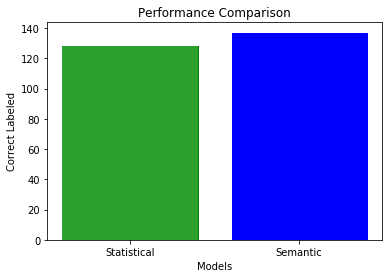

In [63]:
import numpy as np
import matplotlib.pyplot as plt

objects = ("Statistical",
"Semantic"
)
scores = [stat_CM[0][0]+stat_CM[1][1],
sem_CM[0][0]+sem_CM[1][1]]
y_pos = np.arange(len(objects))
plt.bar(y_pos,scores)
plt.bar(y_pos,scores)[0].set_color('g')
plt.bar(y_pos,scores)[1].set_color('b')
plt.xticks(y_pos,objects)
plt.ylabel('Correct Labeled')
plt.xlabel('Models')
plt.title('Performance Comparison')
plt.show()


In [64]:
sem_F1 = f1_score(label_sem_B, label_sem_B_predict.astype(np.float32), average='macro') # from semantcic models
stat_F1 = f1_score(label_B, label_B_predict.astype(np.float32), average='macro') # from statistical models

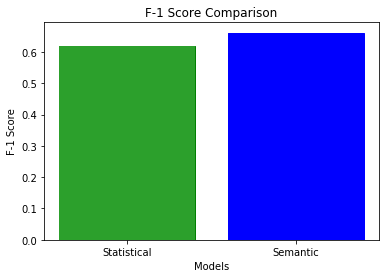

In [65]:
objects = ("Statistical",
"Semantic"
)
scores = [stat_F1, sem_F1]
y_pos = np.arange(len(objects))
plt.bar(y_pos,scores)
plt.bar(y_pos,scores)[0].set_color('g')
plt.bar(y_pos,scores)[1].set_color('b')
plt.xticks(y_pos,objects)
plt.ylabel('F-1 Score')
plt.xlabel('Models')
plt.title('F-1 Score Comparison')
plt.show()

# A Word-Cloud intuition 

In [66]:
from wordcloud import WordCloud

In [67]:
def basic_text_clean(text):
    text = text.replace('. RT ',' ')
    text = text.replace('http://t.co','')
    text = text.replace(' RT ',' ')
    text = text.replace(' co ',' ')
    text = text.replace(' de ',' ')
    return text

In [68]:
tex_A = ''
for i in range(0,frame_A['Document'].shape[0]):
    tex_A = tex_A.strip()+' '+frame_A['Document'][i]

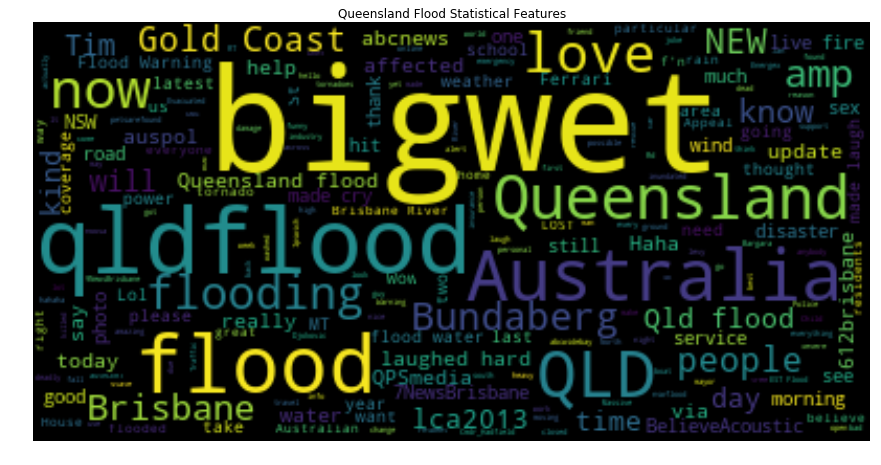

In [69]:
# Generate a word cloud image
wordcloud = WordCloud().generate(basic_text_clean(tex_A))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Queensland Flood Statistical Features')
plt.show()

In [70]:
tex_B = ''
for i in range(0,frame_B['Document'].shape[0]):
    tex_B = tex_B.strip()+' '+frame_B['Document'][i]

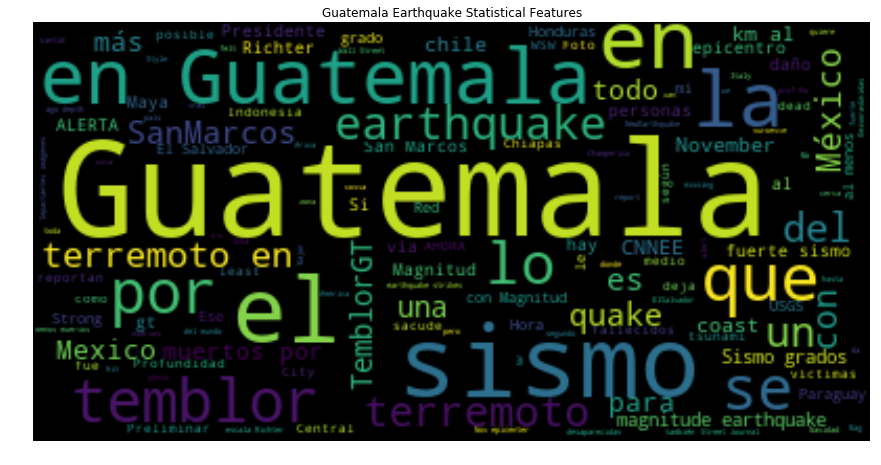

In [71]:
# Generate a word cloud image

wordcloud = WordCloud().generate(basic_text_clean(tex_B))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Guatemala Earthquake Statistical Features')
plt.show()

In [72]:
tex_sem_A = ''
for i in range(0,frame_sem_A['Document'].shape[0]):
    tex_sem_A = tex_sem_A.strip()+' '+frame_sem_A['Document'][i]

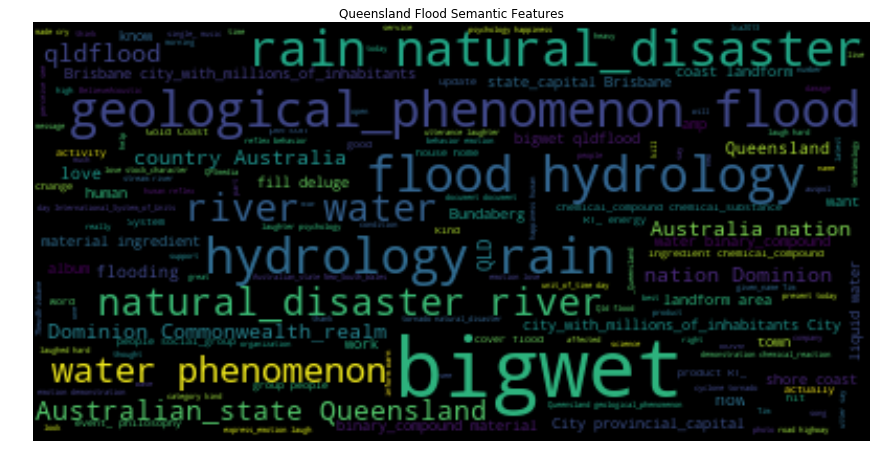

In [73]:
# Generate a word cloud image
wordcloud = WordCloud().generate(basic_text_clean(tex_sem_A))

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Queensland Flood Semantic Features')
plt.show()

In [74]:
tex_sem_B = ''
for i in range(0,frame_sem_B['Document'].shape[0]):
    tex_sem_B = tex_sem_B.strip()+' '+frame_sem_B['Document'][i]

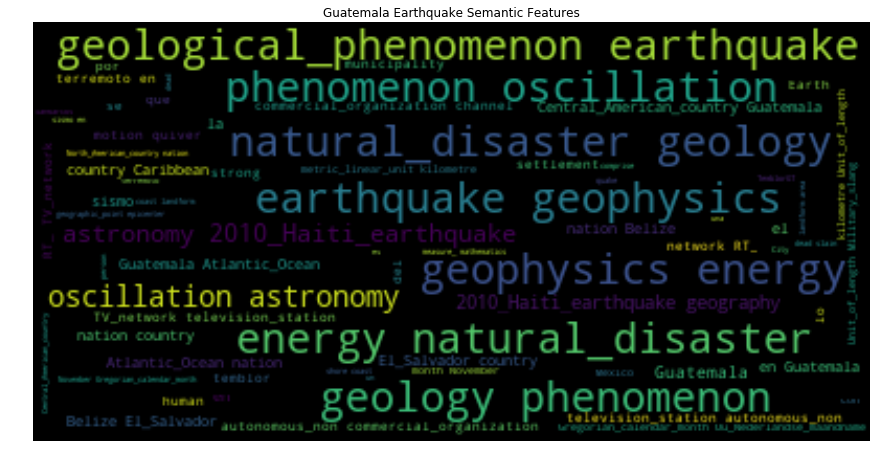

In [75]:
# Generate a word cloud image
wordcloud = WordCloud().generate(basic_text_clean(tex_sem_B))

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Guatemala Earthquake Semantic Features')
plt.show()

# References:

[1]. Khare, P., Fernandez, M. and Alani, H., 2017. Statistical Semantic Classification of
Crisis Information. Workshop on HSSUES at ISWC, Vienna, Austria, 2017

[2]. Khare, P., Burel, G., and Alani, H., Classifying Crises-Information Relevancy with
Semantics. In 15th Extended Semantic Web Conference (ESWC), Crete, 2018